In [4]:
import pandas as pd
import numpy as np

np.random.seed(42)
n_rows = 1500

# Génération des colonnes de base
data = {
    "Prix": np.random.uniform(5, 100, n_rows).round(2),
    "Quantité": np.random.randint(20, 500, n_rows),
    "Promotion": np.random.choice([0, 1], n_rows, p=[0.6, 0.4]),
    "Catégorie_produit": np.random.choice(
        ["Électronique", "Vêtements", "Alimentation", "Maison"], 
        size=n_rows, 
        p=[0.3, 0.25, 0.25, 0.2]
    ),
    "Saison": np.random.choice(
        ["Hiver", "Printemps", "Été", "Automne"], 
        size=n_rows
    ),
}

# Effet promotion sur la quantité (boost de 10% à 50%)
data["Quantité"] = np.where(
    data["Promotion"] == 1,
    data["Quantité"] * np.random.uniform(1.1, 1.5, n_rows).round(0).astype(int),
    data["Quantité"]
)

# Calcul du CA avec variations réalistes
data["CA"] = (data["Prix"] * data["Quantité"] * np.random.normal(1, 0.1, n_rows)).round(2)

# Création du DataFrame
df = pd.DataFrame(data)
df.to_csv("ventes_larges.csv", index=False)

In [10]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# 1. Charger le dataset
df = pd.read_csv("ventes_larges.csv")

# 2. Feature Engineering
# Interaction Saison-Catégorie
df["Saison_Catégorie"] = df["Saison"] + "_" + df["Catégorie_produit"]

# Encodage cyclique des saisons
def encode_saison(saison):
    angle = 2 * np.pi * {"Hiver":0, "Printemps":1, "Été":2, "Automne":3}[saison]/4
    return np.sin(angle), np.cos(angle)

df["Saison_sin"], df["Saison_cos"] = zip(*df["Saison"].map(encode_saison))

# Décalage temporel simulé
df["CA_prev"] = df.groupby(["Catégorie_produit", "Saison"])["CA"].shift(1)
df["CA_prev"] = df["CA_prev"].fillna(df["CA"].mean())

# 3. Préparation des features
numerical_features = ["Prix", "Quantité", "CA_prev", "Saison_sin", "Saison_cos"]
categorical_features = ["Catégorie_produit", "Saison_Catégorie"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# 4. Configuration du modèle
model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(
        n_estimators=300,
        max_depth=12,
        min_samples_leaf=10,
        random_state=42,
        n_jobs=-1
    ))
])

# 5. Entraînement
X = df.drop("CA", axis=1)
y = df["CA"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

# 6. Évaluation
y_pred = model.predict(X_test)
print(f"Performance sur ventes_larges.csv:")
print(f"- R² Score: {r2_score(y_test, y_pred):.3f}")
print(f"- MAE: {mean_absolute_error(y_test, y_pred):.2f} €")

# 7. Exemple de prédiction
exemple = pd.DataFrame([{
    "Prix": 89.99,
    "Quantité": 200,
    "Promotion": 1,
    "Catégorie_produit": "Électronique",
    "Saison": "Été",
    "Saison_Catégorie": "Été_Électronique",
    "CA_prev": 15000.0,
    "Saison_sin": encode_saison("Été")[0],
    "Saison_cos": encode_saison("Été")[1]
}])

print(f"\nPrédiction pour l'exemple: {model.predict(exemple)[0]:.2f} €")

Performance sur ventes_larges.csv:
- R² Score: 0.968
- MAE: 1311.89 €

Prédiction pour l'exemple: 18633.34 €


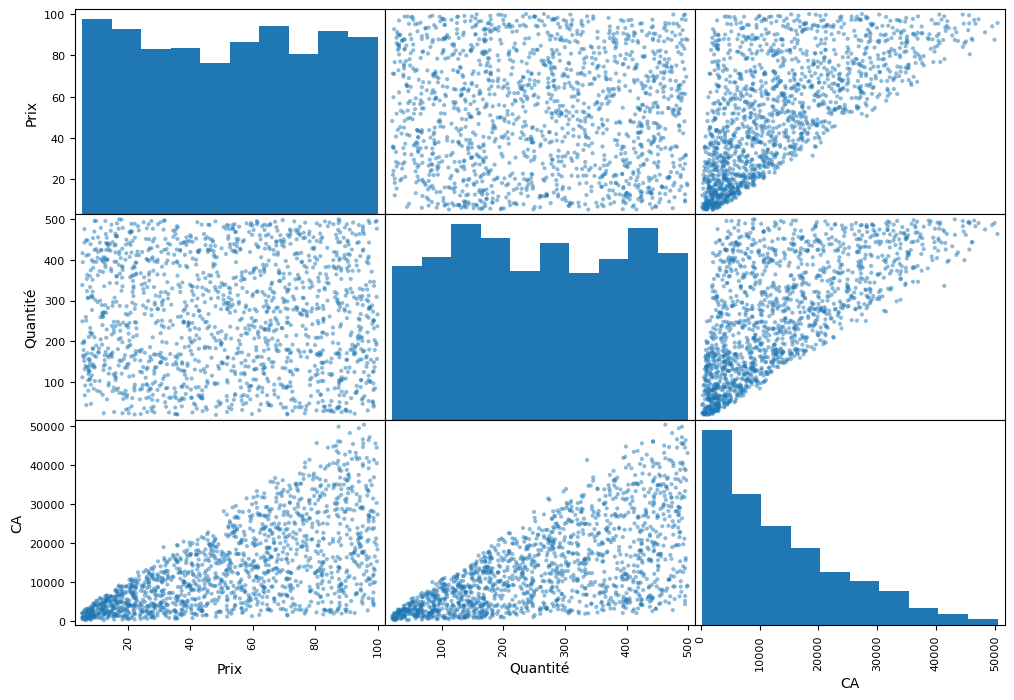

In [11]:
import matplotlib.pyplot as plt

pd.plotting.scatter_matrix(df[['Prix', 'Quantité', 'CA', 'Saison']], figsize=(12, 8))
plt.show()

1-RandomForestRegressor 🌳

Type :
Modèle de régression (prédiction de valeurs numériques).

Utilisé pour :
 Prédire le Chiffre d'Affaires (CA) à partir des variables Prix, Quantité, Promotion, etc.

Fonctionnement :

-Combine plusieurs arbres de décision pour réduire le surajustement et améliorer la précision.
-Gère bien les relations non linéaires et les interactions entre variables.

2. Pipeline avec Prétraitement 🔄
Composants :

OneHotEncoder :
 Pour transformer les variables catégorielles (Catégorie_produit, Saison) en format numérique (ex: "Été" → [0, 0, 1, 0]).

ColumnTransformer :
 Applique des transformations différentes aux colonnes numériques et catégorielles.

RandomForestRegressor : Le modèle final.

Enfin un Pipeline : Chaîne de traitement qui combine prétraitement et modèle.

In [14]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# 1. Charger le dataset
df = pd.read_csv("ventes_larges.csv")

# 2. Feature Engineering (identique au Random Forest)
# Interaction Saison-Catégorie
df["Saison_Catégorie"] = df["Saison"] + "_" + df["Catégorie_produit"]

# Encodage cyclique des saisons
def encode_saison(saison):
    angle = 2 * np.pi * {"Hiver":0, "Printemps":1, "Été":2, "Automne":3}[saison]/4
    return np.sin(angle), np.cos(angle)

df["Saison_sin"], df["Saison_cos"] = zip(*df["Saison"].map(encode_saison))

# Décalage temporel
df["CA_prev"] = df.groupby(["Catégorie_produit", "Saison"])["CA"].shift(1)
df["CA_prev"] = df["CA_prev"].fillna(df["CA"].mean())

# 3. Préparation des features
numerical_features = ["Prix", "Quantité", "CA_prev", "Saison_sin", "Saison_cos"]
categorical_features = ["Catégorie_produit", "Saison_Catégorie"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# 4. Configuration du modèle
model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

# 5. Entraînement
X = df.drop("CA", axis=1)
y = df["CA"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

# 6. Évaluation
y_pred = model.predict(X_test)
print("Performance de la Régression Linéaire:")
print(f"- R² Score: {r2_score(y_test, y_pred):.3f}")
print(f"- MAE: {mean_absolute_error(y_test, y_pred):.2f} €")

# 7. Analyse des coefficients (optionnel)
coefficients = pd.DataFrame({
    "Feature": numerical_features + list(model.named_steps['preprocessor']
                                       .named_transformers_['cat']
                                       .get_feature_names_out(categorical_features)),
    "Coefficient": model.named_steps['regressor'].coef_
})

print("\nTop 10 Coefficients:")
print(coefficients.sort_values("Coefficient", key=abs, ascending=False).head(10))

# 8. Exemple de prédiction
exemple = pd.DataFrame([{
    "Prix": 89.99,
    "Quantité": 200,
    "Promotion": 1,
    "Catégorie_produit": "Électronique",
    "Saison": "Été",
    "Saison_Catégorie": "Été_Électronique",
    "CA_prev": 15000.0,
    "Saison_sin": encode_saison("Été")[0],
    "Saison_cos": encode_saison("Été")[1]
}])

print(f"\nPrédiction pour l'exemple: {model.predict(exemple)[0]:.2f} €")

Performance de la Régression Linéaire:
- R² Score: 0.860
- MAE: 3326.18 €

Top 10 Coefficients:
                                    Feature  Coefficient
17  Saison_Catégorie_Printemps_Alimentation  -698.805957
16      Saison_Catégorie_Hiver_Électronique   688.315171
21        Saison_Catégorie_Été_Alimentation   629.597702
5            Catégorie_produit_Alimentation  -539.765047
24        Saison_Catégorie_Été_Électronique  -483.911553
23           Saison_Catégorie_Été_Vêtements   398.152564
18        Saison_Catégorie_Printemps_Maison  -373.605374
11       Saison_Catégorie_Automne_Vêtements  -354.663161
9     Saison_Catégorie_Automne_Alimentation  -322.693940
8            Catégorie_produit_Électronique   296.723644

Prédiction pour l'exemple: 20093.61 €


1. Préparation des Données
ColumnTransformer :
Combine deux types de traitements :

Colonnes numériques (Prix, Quantité) : Conservées sans modification.

Colonnes catégorielles (Catégorie_produit, Saison, Promotion) : Converties en one-hot encoding (ex: Catégorie_produit=Électronique → [1, 0, 0, 0]).

2. Pipeline
Pipeline : Chaîne d'étapes exécutées séquentiellement :

Prétraitement : Applique le ColumnTransformer.

Modèle : Entraîne une régression linéaire.

3. Régression Linéaire
Principe : Trouve une relation linéaire entre les variables explicatives (X) et la cible (y).


Pourquoi une Performance Plus Faible que Random Forest ?

Relations Non Linéaires :
Le CA dépend probablement de combinaisons complexes (ex: Promotion affecte Quantité, qui interagit avec Prix).
La régression linéaire ne capture pas ces interactions.

Variables Catégorielles :
Le one-hot encoding crée de nombreuses colonnes (ex: 4 saisons → 4 colonnes), ce qui peut diluer l'impact des variables.

Bruit dans les Données :
Le dataset contient du bruit (variations aléatoires), ce qui dégrade les performances des modèles linéaires.

4. Conclusion
Random Forest est clairement supérieur 0.97 > 0.86 (prédiction de CA avec des interactions complexes).

Régression Linéaire reste utile comme baseline ou pour des analyses rapides de tendances.